In [1]:
# input parameters
date_start: str = input("Enter starting date in format YYYY-MM-DD: ")
date_end: str = input("Enter ending date in format YYYY-MM-DD: ")
year = date_end[0:4]

# import libraries

import earthaccess
import xarray as xr
import dask
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from rasterio import features
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Proj, Transformer
from pathlib import Path
import glob
import re

# colormap for plotting sea ice throughout rest of project

cmap = plt.get_cmap("Blues_r").copy()
cmap.set_bad(color='lightgray')

## PASSIVE MICROWAVE SECTION ##

# authenticate NASA earth access
print('Getting NASA Team file list')

auth = earthaccess.login(strategy='interactive', persist = True)

Getting NASA Team file list


In [2]:
# search NASA database for Team

results = earthaccess.search_data(
    short_name= 'NSIDC-0051',
    temporal=(date_start, date_end),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

filtered_results = [
    g for g in results
    if re.search(r'_20\d{6}_', g.data_links(access='external')[0])
]

# get files from NSIDC

files_team = earthaccess.open(filtered_results)

# search NASA database for Bootstrap
print('Getting NASA Bootstrap file list')

results = earthaccess.search_data(
    short_name= 'NSIDC-0079',
    temporal=(date_start, date_end),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

filtered_results = [
    g for g in results
    if re.search(r'_20\d{6}_', g.data_links(access='external')[0])
]

# get files from NSIDC

files_bootstrap = earthaccess.open(filtered_results)

QUEUEING TASKS | :   0%|          | 0/347 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/347 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/347 [00:00<?, ?it/s]

Getting NASA Bootstrap file list


QUEUEING TASKS | :   0%|          | 0/348 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/348 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/348 [00:00<?, ?it/s]

In [3]:
# stream team into xarray
print('Opening daily NASA Team data into array')

ds = xr.open_mfdataset(
    files_team, 
    parallel = True, 
    concat_dim="time", 
    combine="nested", 
    data_vars='minimal', 
    coords='minimal', 
    compat='override'
)

# change ice concentration variable to something universal

icecon_vars = sorted([var for var in ds.data_vars if 'ICECON'in var], reverse=True)
icecon = ds[icecon_vars].to_array("source").max("source", skipna=True)

# add back to dataset and clean up
ds = ds.assign(team_icecon=icecon).drop_vars(icecon_vars)

# stream bootstrap into xarray
print('Opening daily NASA Bootstrap data into array')
ds_bootstrap = xr.open_mfdataset(
    files_bootstrap, 
    parallel = True, 
    concat_dim="time", 
    combine="nested", 
    data_vars='minimal', 
    coords='minimal', 
    compat='override'
)

# change ice concentration variable to something universal

icecon_vars = sorted([var for var in ds_bootstrap.data_vars if 'ICECON'in var], reverse=True)
icecon = ds_bootstrap[icecon_vars].to_array("source").max("source", skipna=True)

# add back to dataset and clean up
ds = ds.assign(bootstrap_icecon=icecon)

Opening daily NASA Team data into array
Opening daily NASA Bootstrap data into array


In [ ]:
visual

In [43]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:           (col: 304, row: 448, time: 347)
Coordinates:
    x                 (col) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
    y                 (row) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time              (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
  * row               (row) int64 4kB 0 1 2 3 4 5 6 ... 442 443 444 445 446 447
  * col               (col) int64 2kB 0 1 2 3 4 5 6 ... 298 299 300 301 302 303
Data variables:
    crs               |S1 1B ...
    team_icecon       (time, row, col) float64 378MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    bootstrap_icecon  (time, row, col) float64 378MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    edtl              (row, col) float64 1MB 106.5 105.6 104.7 ... 15.52 15.81
    visual_ice        (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
Attributes: (12/49)
    title:                     Sea Ice Concentrations from Nimbus-7 SMMR and ...
    summary:                   This data set is generated from brightness tem...
    id:                        10.5067/MPYG15WAA4WX
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/MPYG15WAA4WX
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    Polar stereographic brightness temperatures fr...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounder
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...

In [42]:
# export metadata

with open("xarray_metadata.txt", "w") as f:
    f.write("=== Global Attributes ===\n")
    for k, v in ds.attrs.items():
        f.write(f"{k}: {v}\n")

    f.write("\n=== Variables ===\n")
    for var in ds.data_vars:
        f.write(f"\n[{var}]\n")
        for k, v in ds[var].attrs.items():
            f.write(f"  {k}: {v}\n")
        # include shape and dtype too
        f.write(f"  shape: {ds[var].shape}\n")
        f.write(f"  dtype: {ds[var].dtype}\n")

    f.write("\n=== Coordinates ===\n")
    for coord in ds.coords:
        f.write(f"\n[{coord}]\n")
        for k, v in ds[coord].attrs.items():
            f.write(f"  {k}: {v}\n")
        f.write(f"  shape: {ds[coord].shape}\n")
        f.write(f"  dtype: {ds[coord].dtype}\n")

In [4]:
# read in land file from geopandas and initialize transform (from NSIDC metadata)
print('Calculating distance from land for each pixel')

land = gpd.read_file("../data/ne_10m_land/ne_10m_land.shp")
land = land.to_crs(epsg=3411)
transform = [25000, 0, -3837500, 0, -25000, 5837500]

# use transform to mask out coastal cells

land_mask = features.rasterize(
    ((geom, 1) for geom in land.geometry),
    out_shape=(448, 304),
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# calculate distance from land using euclidian distance transform

distance_from_land = distance_transform_edt(land_mask == 0)

# convert to xarray.DataArray

distance_xr = xr.DataArray(
    distance_from_land,
    coords={'y': ds.y, 'x': ds.x},
    dims=('y', 'x'),
    name='distance_to_land_cells'
)

# add as data variable in ds

ds['edtl'] = distance_xr

Calculating distance from land for each pixel


In [5]:
# NEW — COULD BE BUGGY
# resindex dataset

nrows = ds.sizes['y']
ncols = ds.sizes['x']

ds = ds.assign_coords({
    'row': ('y', np.arange(nrows)),
    'col': ('x', np.arange(ncols))
}).swap_dims({'y': 'row', 'x': 'col'})

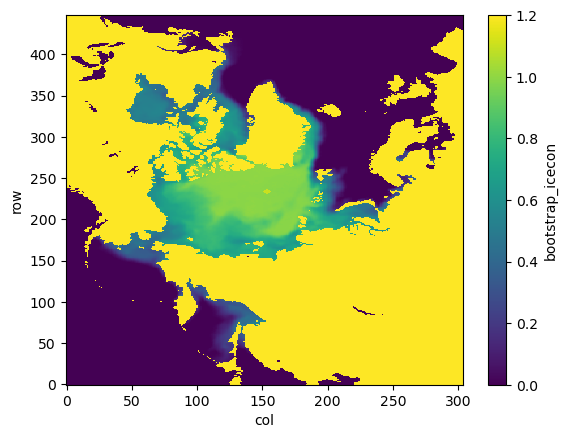

In [10]:
ds.bootstrap_icecon.mean(dim='time').plot()

In [17]:
## VISUAL ICE SECTION ##
# create visual PANDAS DATAFRAME
print('Reading in and engineering visual data')

# read in files

folderpath = '../local_data/visual_ice/'
paths = Path(folderpath).glob(f'*{year}*.csv')
pathlist = list(paths)

# data cleaning of visual datasets

visual = pd.concat(map(pd.read_csv, pathlist), ignore_index=True)

# convert things for xarray

visual["time"] = pd.to_datetime(visual["Date"], yearfirst=True)
visual['row'] = visual['Column'] - 1
visual['col'] = visual['Row'] - 1

# drop duplicates

visual = visual.drop_duplicates(subset=["time", "row", "col"])

Reading in and engineering visual data


In [18]:
visual

,system:index,Cloud cover,Column,Date,Land frac,Ocean frac,Row,SI frac,Scene ID,Snow frac,Sun azimuth,Sun elevation,WRS path,WRS row,total pixels,.geo,time,row,col
0,0000000000000000011b,2.65,171.0,2023-07-12,1.000000,0.000000,67.0,0.000000,LC81622312023193LGN00,0.000000,-43.979653,5.858804,162.0,231.0,54,"{""type"":""Polygon"",""coordinates"":[[[-170.802032...",2023-07-12,170.0,66.0
1,0000000000000000011c,2.65,172.0,2023-07-12,0.978664,0.000000,67.0,0.000000,LC81622312023193LGN00,0.021336,-43.979653,5.858804,162.0,231.0,77475,"{""type"":""Polygon"",""coordinates"":[[[-170.786917...",2023-07-12,171.0,66.0
2,0000000000000000011d,2.65,173.0,2023-07-12,0.953200,0.037708,67.0,0.006185,LC81622312023193LGN00,0.002907,-43.979653,5.858804,162.0,231.0,224250,"{""type"":""Polygon"",""coordinates"":[[[-170.277856...",2023-07-12,172.0,66.0
3,0000000000000000011e,2.65,174.0,2023-07-12,0.257292,0.357888,67.0,0.383439,LC81622312023193LGN00,0.001381,-43.979653,5.858804,162.0,231.0,370750,"{""type"":""Polygon"",""coordinates"":[[[-169.765163...",2023-07-12,173.0,66.0
4,00000000000000000145,2.65,171.0,2023-07-12,0.912480,0.000000,68.0,0.000000,LC81622312023193LGN00,0.087520,-43.979653,5.858804,162.0,231.0,528955,"{""type"":""Polygon"",""coordinates"":[[[-171.448671...",2023-07-12,170.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2421,0000000000000000063a,0.01,262.0,2023-06-02,0.000676,0.000000,125.0,0.024198,LC80650012023153LGN00,0.975126,-141.875781,29.654292,65.0,1.0,596365,"{""type"":""Polygon"",""coordinates"":[[[-91.0050861...",2023-06-02,261.0,124.0
2422,0000000000000000063d,0.00,261.0,2023-08-19,0.379126,0.062127,126.0,0.142699,LC80672462023231LGN00,0.416048,-115.940011,16.321160,67.0,246.0,608814,"{""type"":""Polygon"",""coordinates"":[[[-91.0416267...",2023-08-19,260.0,125.0
2423,00000000000000000640,0.00,260.0,2023-08-19,0.398244,0.006796,127.0,0.000000,LC80672462023231LGN00,0.594960,-115.940011,16.321160,67.0,246.0,685258,"{""type"":""Polygon"",""coordinates"":[[[-91.0809243...",2023-08-19,259.0,126.0
2424,00000000000000000642,0.00,259.0,2023-08-19,0.548814,0.000986,128.0,0.000000,LC80672462023231LGN00,0.450200,-115.940011,16.321160,67.0,246.0,718752,"{""type"":""Polygon"",""coordinates"":[[[-91.1233028...",2023-08-19,258.0,127.0


In [ ]:
# CREATE VISUAL ARRAY
# convert to xarray

da_sparse = visual.set_index(['time', 'row', 'col']).to_xarray()
da_full = da_sparse.reindex_like(ds, method=None)

da_full = da_full.chunk({'time': 2})
ds = ds.assign(**{'visual_ice': da_full['SI frac']})
ds = ds.assign(**{'ocean_fraction': da_full['Ocean frac']})
ds = ds.assign(**{'land_fraction': da_full['Land frac']})
ds = ds.assign(**{'snow_fraction': da_full['Snow frac']})
ds = ds.assign(**{'sun_elevation': da_full['Sun elevetation']})
ds = ds.assign(**{'cloud_cover': da_full['Cloud cover']})
da_full

<xarray.Dataset> Size: 6GB
Dimensions:        (time: 347, row: 448, col: 304)
Coordinates:
  * time           (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
  * row            (row) int64 4kB 0 1 2 3 4 5 6 ... 441 442 443 444 445 446 447
  * col            (col) int64 2kB 0 1 2 3 4 5 6 ... 297 298 299 300 301 302 303
Data variables: (12/16)
    system:index   (time, row, col) object 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
    Cloud cover    (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
    Column         (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
    Date           (time, row, col) object 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
    Land frac      (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
    Ocean frac     (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
    ...             ...
    Sun azimuth    (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
    Sun elevation  (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
    WRS path       (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
    WRS row        (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
    total pixels   (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
    .geo           (time, row, col) object 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>

In [20]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:           (col: 304, row: 448, time: 347)
Coordinates:
    x                 (col) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
    y                 (row) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time              (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
  * row               (row) int64 4kB 0 1 2 3 4 5 6 ... 442 443 444 445 446 447
  * col               (col) int64 2kB 0 1 2 3 4 5 6 ... 298 299 300 301 302 303
Data variables:
    crs               |S1 1B ...
    team_icecon       (time, row, col) float64 378MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    bootstrap_icecon  (time, row, col) float64 378MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    edtl              (row, col) float64 1MB 106.5 105.6 104.7 ... 15.52 15.81
    visual_ice        (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
Attributes: (12/49)
    title:                     Sea Ice Concentrations from Nimbus-7 SMMR and ...
    summary:                   This data set is generated from brightness tem...
    id:                        10.5067/MPYG15WAA4WX
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/MPYG15WAA4WX
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    Polar stereographic brightness temperatures fr...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounder
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...

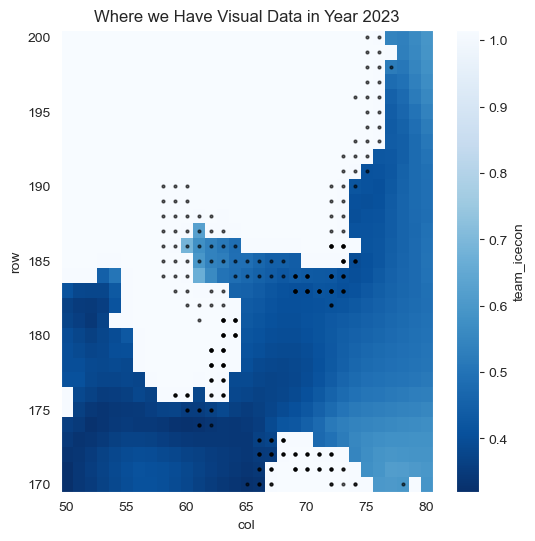

In [39]:
# sanity check to make sure everything works
# THIS PLOT DIDNT WORK IN ORIGINAL SCRIPT

# col_min, col_max = visual['col'].min(), visual['col'].max()
# row_min, row_max = visual['row'].min(), visual['row'].max()

col_min, col_max = [50, 80]
row_min, row_max = [170, 200]

ds_subset = ds.sel(col=slice(col_min, col_max), row=slice(row_min, row_max))
ax = ds_subset.team_icecon.mean(dim='time').plot(
    cmap=cmap,
    figsize=(6,6)
)

visual_shifted = visual
visual_shifted['row'] = visual_shifted['row'] - 1
visual_shifted['col'] = visual_shifted['col'] - 1

plt.scatter(
    visual_shifted['col'],
    visual_shifted['row'],
    color='black',
    s=4,
    alpha=0.6
)
plt.title(f"Where we Have Visual Data in Year {year}")
plt.show()
plt.close()

In [24]:
# print dataset

print('Printing dataset with visual, team, bootstrap, and distance from land')
print(ds)

Printing dataset with visual, team, bootstrap, and distance from land
<xarray.Dataset> Size: 1GB
Dimensions:           (col: 304, row: 448, time: 347)
Coordinates:
    x                 (col) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
    y                 (row) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time              (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
  * row               (row) int64 4kB 0 1 2 3 4 5 6 ... 442 443 444 445 446 447
  * col               (col) int64 2kB 0 1 2 3 4 5 6 ... 298 299 300 301 302 303
Data variables:
    crs               |S1 1B ...
    team_icecon       (time, row, col) float64 378MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    bootstrap_icecon  (time, row, col) float64 378MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    edtl              (row, col) float64 1MB 106.5 105.6 104.7 ... 15.52 15.81
    visual_ice        (time, row, col) float64 378MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
Attri

In [ ]:
# ERROR FOR TEAM

condition = ((ds.visual_ice.notnull()) & (ds.team_icecon < 1.001))
ds_clean = ds.where(condition, other=np.nan).compute()
ds_clean

<xarray.Dataset> Size: 2GB
Dimensions:           (time: 347, row: 448, col: 304)
Coordinates:
    x                 (col) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
    y                 (row) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time              (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
  * row               (row) int64 4kB 0 1 2 3 4 5 6 ... 442 443 444 445 446 447
  * col               (col) int64 2kB 0 1 2 3 4 5 6 ... 298 299 300 301 302 303
Data variables:
    crs               (time, row, col) object 378MB nan nan nan ... nan nan nan
    team_icecon       (time, row, col) float64 378MB nan nan nan ... nan nan nan
    bootstrap_icecon  (time, row, col) float64 378MB nan nan nan ... nan nan nan
    edtl              (row, col, time) float64 378MB nan nan nan ... nan nan nan
    visual_ice        (time, row, col) float64 378MB nan nan nan ... nan nan nan
Attributes: (12/49)
    title:                     Sea Ice Concentrations from Nimbus-7 SMMR and ...
    summary:                   This data set is generated from brightness tem...
    id:                        10.5067/MPYG15WAA4WX
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/MPYG15WAA4WX
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    Polar stereographic brightness temperatures fr...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounder
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...

In [ ]:
# calc error

error_team = (((ds_clean['team_icecon'] - ds_clean['visual_ice'])**2)**0.5)
error_avg = error_team.mean(dim=['time', 'col', 'row'], skipna=True)
print('RMS error for NASA Team is', error_avg.compute().item())

# save a data cleaned pandas dataframe for team with everything (1.012 = coast, 1.016 = land)

df = ds_clean.to_dataframe().reset_index().dropna()
df

Starting error calculations
RMS error for NASA Team is 0.4443231100558371


,time,row,col,crs,team_icecon,bootstrap_icecon,edtl,visual_ice,x,y
8256713,2023-03-05,280,73,b'',0.948,0.961,1.000000,0.612180,-2012500.0,-1162500.0
8257017,2023-03-05,281,73,b'',0.948,0.968,1.000000,0.826946,-2012500.0,-1187500.0
8257018,2023-03-05,281,74,b'',0.960,0.961,0.000000,0.044620,-1987500.0,-1187500.0
8257322,2023-03-05,282,74,b'',0.948,0.961,1.000000,0.533653,-1987500.0,-1212500.0
8258841,2023-03-05,287,73,b'',0.956,0.972,1.414214,0.996431,-2012500.0,-1337500.0
...,...,...,...,...,...,...,...,...,...,...
41042202,2023-11-15,159,74,b'',0.064,0.000,1.000000,0.000000,-1987500.0,1862500.0
41042203,2023-11-15,159,75,b'',0.076,0.000,0.000000,0.001220,-1962500.0,1862500.0
41042204,2023-11-15,159,76,b'',0.004,0.000,1.000000,0.023225,-1937500.0,1862500.0
41042509,2023-11-15,160,77,b'',0.000,0.000,1.000000,0.122988,-1912500.0,1837500.0


In [26]:
# ERROR FOR BOOTSTRAP

condition = ((ds.visual_ice.notnull()) & (ds.bootstrap_icecon < 1.001))
ds_clean = ds.where(condition, other=np.nan).compute()

# error calculation bootstrap

error_bootstrap = (((ds_clean['bootstrap_icecon'] - ds_clean['visual_ice'])**2)**0.5)
error_avg = error_bootstrap.mean(dim=['time', 'col', 'row'], skipna=True)
print('RMS error for NASA Bootstrap is', error_avg.compute().item())

# save a data cleaned pandas dataframe for boostrap with everything (1.012 = coast, 1.016 = land)

df_2 = ds_clean.to_dataframe().reset_index().dropna()
df_2

RMS error for NASA Bootstrap is 0.46849538073681257


,time,row,col,crs,team_icecon,bootstrap_icecon,edtl,visual_ice,x,y
8256713,2023-03-05,280,73,b'',0.948,0.961,1.000000,0.612180,-2012500.0,-1162500.0
8257017,2023-03-05,281,73,b'',0.948,0.968,1.000000,0.826946,-2012500.0,-1187500.0
8257018,2023-03-05,281,74,b'',0.960,0.961,0.000000,0.044620,-1987500.0,-1187500.0
8257322,2023-03-05,282,74,b'',0.948,0.961,1.000000,0.533653,-1987500.0,-1212500.0
8258841,2023-03-05,287,73,b'',0.956,0.972,1.414214,0.996431,-2012500.0,-1337500.0
...,...,...,...,...,...,...,...,...,...,...
41042202,2023-11-15,159,74,b'',0.064,0.000,1.000000,0.000000,-1987500.0,1862500.0
41042203,2023-11-15,159,75,b'',0.076,0.000,0.000000,0.001220,-1962500.0,1862500.0
41042204,2023-11-15,159,76,b'',0.004,0.000,1.000000,0.023225,-1937500.0,1862500.0
41042509,2023-11-15,160,77,b'',0.000,0.000,1.000000,0.122988,-1912500.0,1837500.0


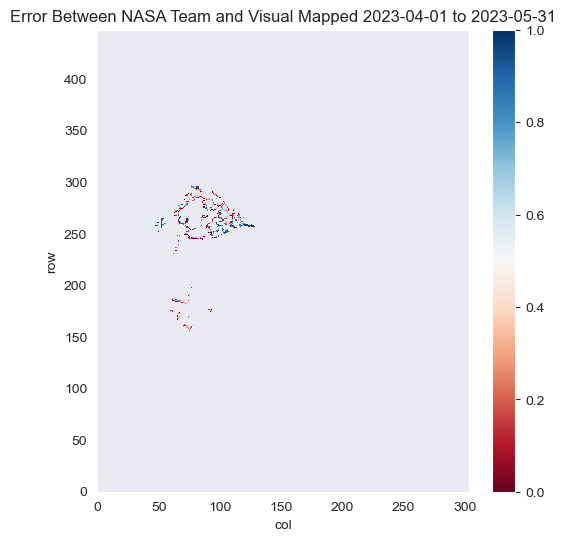

In [31]:
# map error NASA team

sns.set_style('darkgrid')
ax = error_team.mean(dim='time', skipna=True).plot(cmap = 'RdBu', figsize=(6,6))
plt.title(f"Error Between NASA Team and Visual Mapped 2023-04-01 to 2023-05-31")
plt.show()
plt.close()

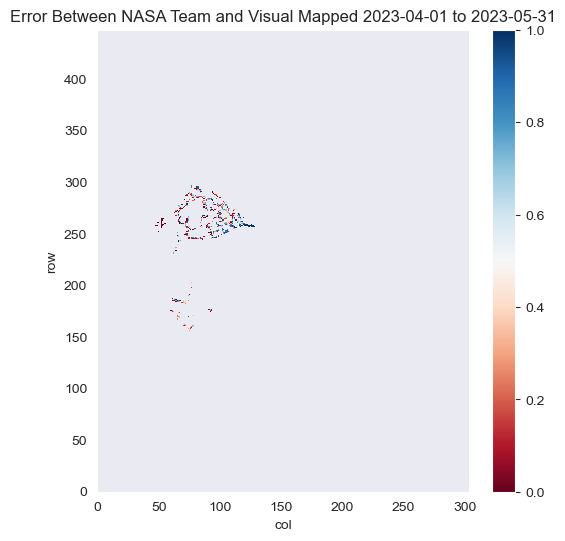

In [32]:
# map error NASA bootstrap

ax = error_bootstrap.mean(dim='time', skipna=True).plot(cmap = 'RdBu', figsize=(6,6))
plt.title(f"Error Between NASA Team and Visual Mapped 2023-04-01 to 2023-05-31")
plt.show()
plt.close()